In [1]:
import os
import keras
import shutil
from re import sub
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import plot, legend, show, xlabel, ylabel, title

from keras import layers
import keras_nlp

from helper import init_resource_dicts, get_arrays, get_strings

# LSTM implementation # parameters ~ 10K

/Users/tianyiniu/miniconda3/envs/mlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def initialize_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    else:
        for filename in os.listdir(directory_path):
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove file or symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory and its contents

initialize_directory('./Transformer_Run_Results/')

Hyperparameters:

In [105]:
batch_size = 32  #Batch size for training
latent_dim = 32  #Latent dimensionality of the encoding space.

epochs = 30  #Number of epochs to train for
reps = 5 #Repetitions in each condition

Files and resource dictionaries:

In [106]:
feat_file = "./Feature_files/featsNew"
stim_sets = ["EqualDefault/equalFreq", "MajDefault/majDefault", "MinDefault/minDefault"] #Need a training file for each stim_set
test_sets = ["test", "test_Mutants", "testNewTemplates", "test_L", "test_H"] #Need a file for each of these test sets for each stim_set
WRITE_OUT = True

symbol2feats, suffix2label, label2suffix = init_resource_dicts(feat_file)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_weights(attention_weights, layer_index):
    fig, ax = plt.subplots(figsize=(8, 6))
    attention = attention_weights[layer_index][0]  # Shape: (num_heads, seq_len, seq_len)
    
    # Average attention weights across all heads
    attention_avg = np.mean(attention, axis=0)
    
    im = ax.imshow(attention_avg, cmap='viridis')
    
    ax.set_xticks(np.arange(attention_avg.shape[1]))
    ax.set_yticks(np.arange(attention_avg.shape[0]))
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Token Position')
    ax.set_title(f'Attention Weights - Layer {layer_index + 1}')
    
    plt.colorbar(im)
    plt.show()

# Assuming you have your model predictions and attention weights:
# predictions, *attention_weights = model.predict(sample_input)

# Plot attention weights for each layer
# for i in range(len(attention_weights)):
#     plot_attention_weights(attention_weights, i)

In [107]:
def encoder_layer(d_model, num_heads, dff, dropout_rate):
    inputs = keras.Input(shape=(None, d_model))
    attention = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
    attention_output = attention(inputs, inputs)
    attention_output = keras.layers.Dropout(dropout_rate)(attention_output)
    attention_output = keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    outputs = keras.layers.Dense(dff, activation="relu")(attention_output)
    outputs = keras.layers.Dense(d_model)(outputs)
    outputs = keras.layers.Dropout(dropout_rate)(outputs)
    outputs = keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + outputs)
    
    return keras.Model(inputs=inputs, outputs=outputs)


def get_encoder_model(num_layers=1, d_model=32, num_heads=1, dff=64, dropout_rate=0.1):
    # 5 time steps, 19 features
    encoder_inputs = keras.Input(shape=(5, 19)) 
    
    position_embeddings = keras_nlp.layers.PositionEmbedding(sequence_length=5)(encoder_inputs)
    encoder_outputs = encoder_inputs + position_embeddings

    encoder_outputs = keras.layers.Dense(d_model)(encoder_outputs)
    
    # Encoder implementation
    for _ in range(num_layers):
        encoder_outputs = encoder_layer(d_model, num_heads, dff, dropout_rate)(encoder_outputs)
    
    # Classification head
    outputs = keras.layers.Flatten()(encoder_outputs)
    outputs = keras.layers.Dense(3, activation="softmax")(outputs) 
    
    return keras.Model(inputs=encoder_inputs, outputs=outputs)

In [108]:
def get_test_results(test_preds):
    return [label2suffix[label] for label in test_preds]

def get_accuracies(corr_out, pred_out):
    assert len(corr_out) == len(pred_out)
    correct = 0
    for corr_label, pred_label in zip(corr_out, pred_out):
        correct += 1 if corr_label == pred_label else 0
    return correct / len(corr_out)

def log_test_accuracies(model, epoch):
    epoch_filepath = f"./Transformer_Run_Results/minDef_epoch{epoch}_output.csv"
    
    with open(epoch_filepath, "w", encoding="utf-8") as log_file_handle:
        log_file_handle.write("Set,TestSet,Rep,Input,CorrOutput,PredOutput,Epoch\n")
        for my_set in stim_sets:
            for ts in test_sets:
                # print("\t"+ts)

                #Load the testing data:
                test_URs, test_SRs, test_Ls = get_strings(my_set+"_"+ts+".txt")
                test_X, test_Y = get_arrays(test_URs, test_SRs, test_Ls, symbol2feats, suffix2label, override_max_syll=5)

                for rep in range(reps):
                    #Load a previous model:
                    stim_set_name = my_set.split("/")[-1]

                    #Test the model:
                    predictions = model.predict(test_X, verbose=0)
                    predictions = tf.math.argmax(predictions, axis=1).numpy().tolist() # Labels
                    preds = get_test_results(predictions) # Suffix strings

                    acc = get_accuracies(test_Y, predictions)
                    # print(f"\t\tRep: {rep}, Acc: {acc:.{3}}")

                    #Record everything:
                    for i, co, po in zip(test_URs, test_SRs, preds):
                            log_file_handle.write(",".join([stim_set_name, ts, str(rep), i, co, po, str(epoch)])+"\n")


class AccuracyCallback(keras.callbacks.Callback):
    def __init__(self):
        super(AccuracyCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        log_test_accuracies(self.model, epoch)


In [109]:
allLosses = []
allAccs = []
accCallback = AccuracyCallback()

for my_set in stim_sets:
    #Load the training data:
    URs, SRs, Ls = get_strings(my_set+"_train.txt")
    X, Y = get_arrays(URs, SRs, Ls, symbol2feats, suffix2label, override_max_syll=5)

    Y = tf.keras.utils.to_categorical(Y, num_classes = 3)

    for rep in range(reps):
        print("Rep: ", rep, ", Set:", my_set)

        model = get_encoder_model()
        
        # my_opt = keras.optimizers.RMSprop(learning_rate=lr)
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )

        hist = model.fit(X, Y, batch_size=batch_size, epochs=epochs,
            validation_split=0, verbose=1, callbacks=[accCallback])
        
        # Save model
        stim_set_name = my_set.split("/")[-1]
        model.save(f"./Transformer_Run_Results/{stim_set_name}_model_{rep}.keras")

        # Save the loss:
        allLosses.append(hist.history["loss"])
        allAccs.append(hist.history["accuracy"])

Rep:  0 , Set: EqualDefault/equalFreq
Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.4032 - loss: 1.3298
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6415 - loss: 0.8034
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8507 - loss: 0.4393
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9150 - loss: 0.2741
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9680 - loss: 0.1434
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9934 - loss: 0.0787
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9999 - loss: 0.0467
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 1.0000 - loss: 0.0326
Epoch 9/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9998 - loss: 0.0203
Epoch 10/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 1.0000 - loss: 0.0169
Epoch 11/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9994 - loss: 0.0098
Epoch 12/30
38/38 ━━━━━━

Plot learning curves (averaged over all runs and conditions):

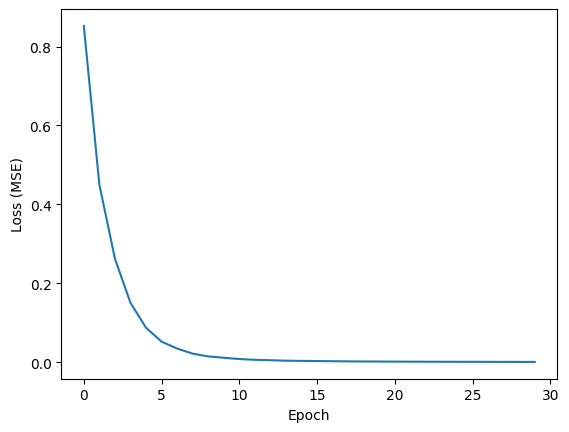

In [110]:
#Plot average loss (for checking lr, etc.)
av_curve = np.mean(allLosses, axis=0)
plot(av_curve)
xlabel("Epoch")
ylabel("Loss (MSE)")
show()

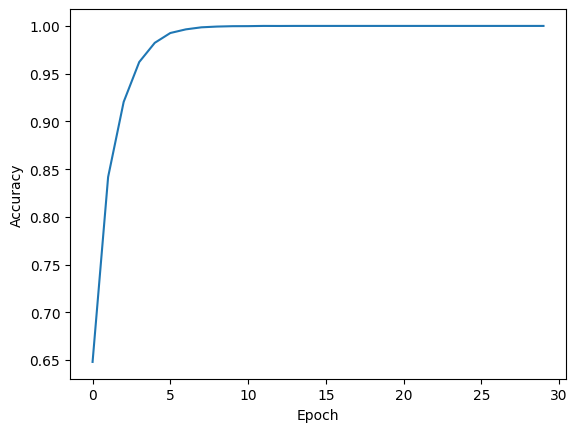

In [111]:
#Plot average accuracy on training (for checking lr, etc.)
av_curve = np.mean(allAccs, axis=0)
plot(av_curve)
xlabel("Epoch")
ylabel("Accuracy")
show()